In [4]:
# load library
import argparse
import os
import numpy as np
from tqdm import tqdm

from mypath import Path
from dataloaders import make_data_loader
from modeling.sync_batchnorm.replicate import patch_replication_callback
from modeling.deeplab import *
from utils.loss import SegmentationLosses
from utils.calculate_weights import calculate_weigths_labels
from utils.lr_scheduler import LR_Scheduler
from utils.saver import Saver
from utils.summaries import TensorboardSummary
from utils.metrics import Evaluator

from dataloaders.datasets.lits import LiverSegmentation, TumorSegmentation
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import argparse
from PIL import Image
import cv2
import time
import torch

In [5]:
from scipy.ndimage import morphology

def surfd(input1, input2, sampling=1, connectivity=1):
    
    input_1 = np.atleast_1d(input1.astype(np.bool))
    input_2 = np.atleast_1d(input2.astype(np.bool))
    

    conn = morphology.generate_binary_structure(input_1.ndim, connectivity)

    S = input_1 ^ morphology.binary_erosion(input_1, conn)
    Sprime = input_2 ^ morphology.binary_erosion(input_2, conn)

    
    dta = morphology.distance_transform_edt(~S,sampling)
    dtb = morphology.distance_transform_edt(~Sprime,sampling)
    
    sds = np.concatenate([np.ravel(dta[Sprime!=0]), np.ravel(dtb[S!=0])])
       
    
    return sds

In [9]:
parser = argparse.ArgumentParser()
parser.add_argument('-f')
parser.add_argument('--batch-size', type=int, default=200)
parser.add_argument('--base-size', type=int, default=256)
parser.add_argument('--crop-size', type=int, default=256)
parser.add_argument('--mode', type=str, default='vis')
parser.add_argument('--kind', type=str, default='liver')
parser.add_argument('--model-path', type=str, default='models/95_liver33.pth.tar')
args = parser.parse_args()

ERROR! Session/line number was not unique in database. History logging moved to new session 2


In [7]:
# load model
model = DeepLab(num_classes=2, backbone='xception', output_stride=16, sync_bn=False, freeze_bn=False)

# ckpt = torch.load('run/lits_tumor/resume-tumor-bce-crop/experiment_0/_checkpoint37.pth.tar')#67 0.8809 0.8809
ckpt = torch.load(args.model_path)#72 
state_dict = ckpt['state_dict']
model.load_state_dict(state_dict)

<All keys matched successfully>

num test img:  3568


/tmp/ipykernel_90/2580060943.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


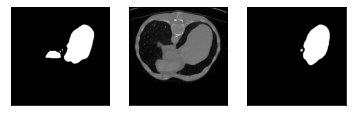

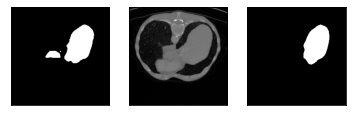

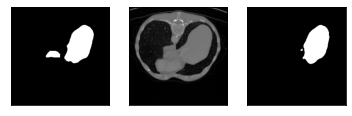

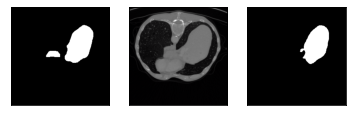

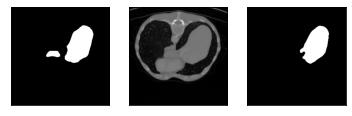

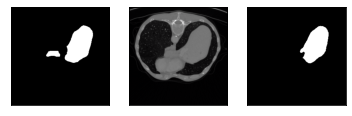

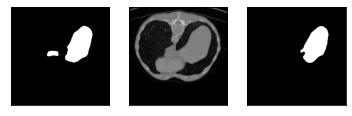

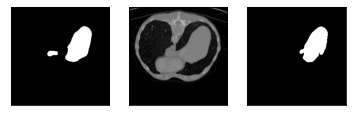

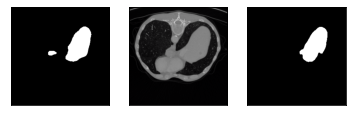

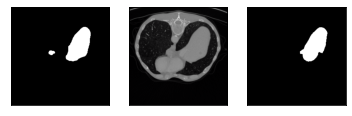

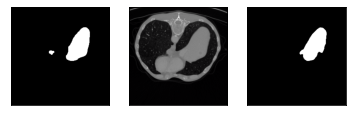

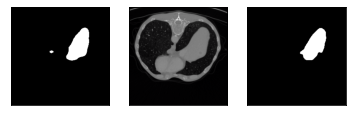

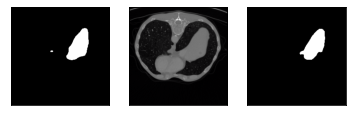

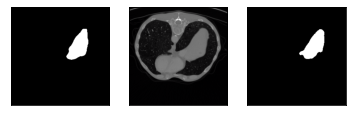

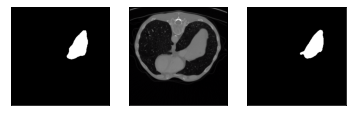

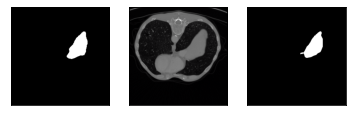

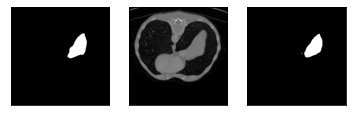

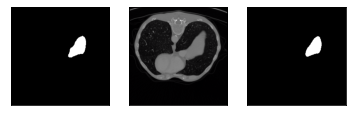

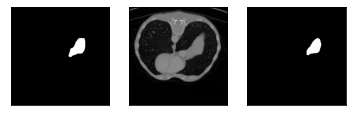

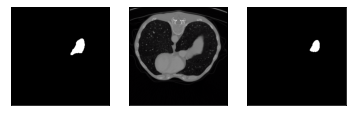

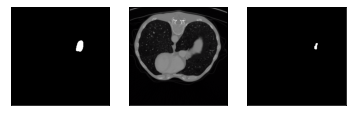

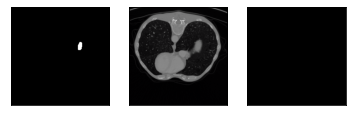

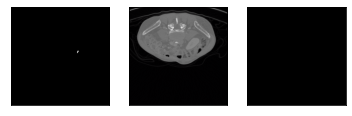

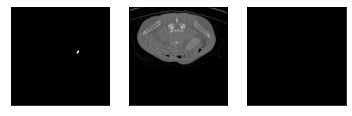

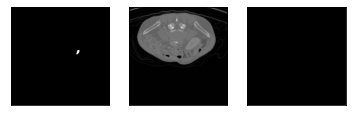

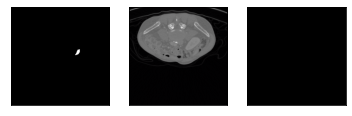

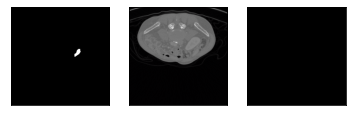

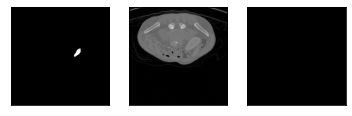

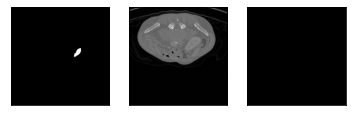

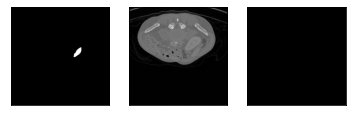

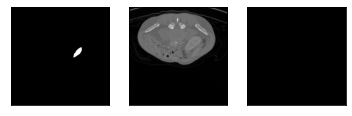

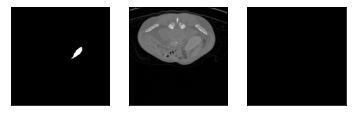

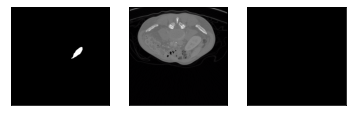

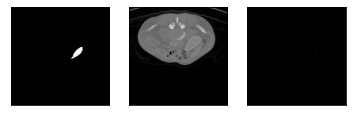

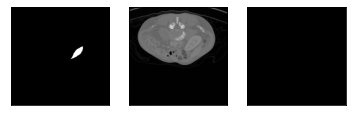

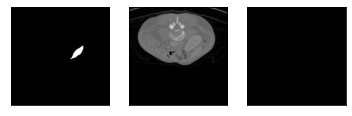

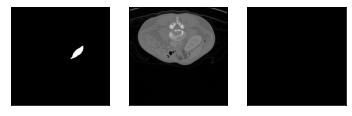

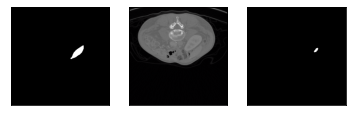

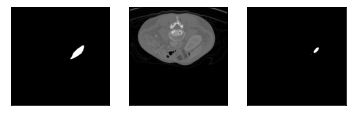

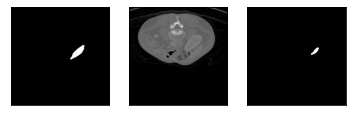

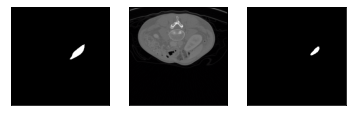

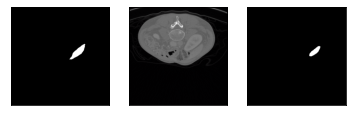

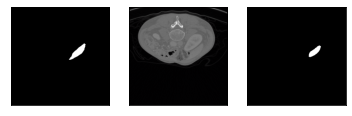

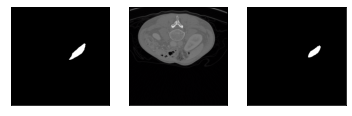

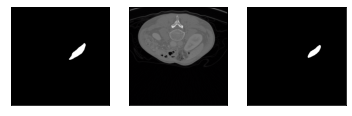

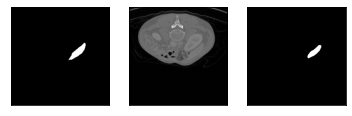

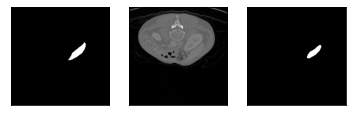

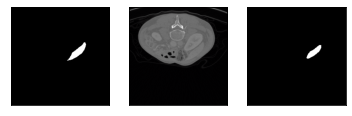

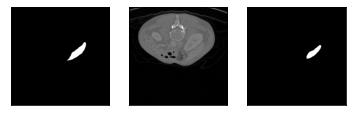

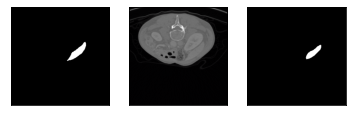

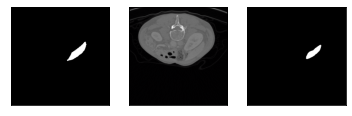

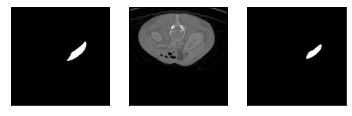

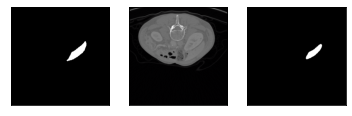

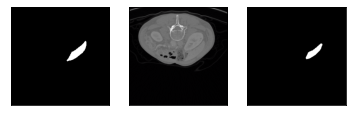

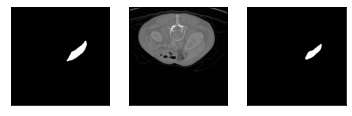

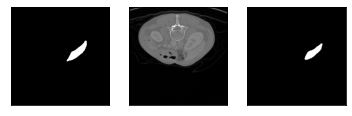

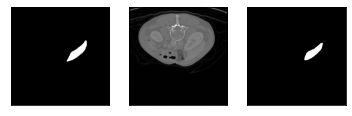

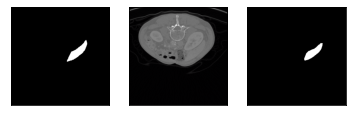

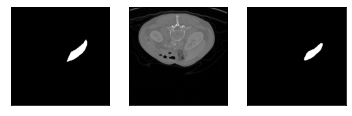

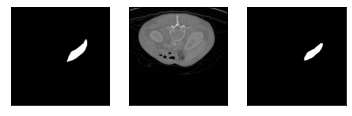

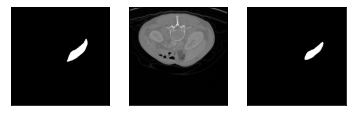

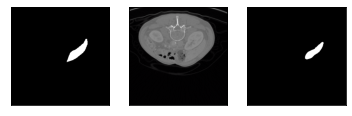

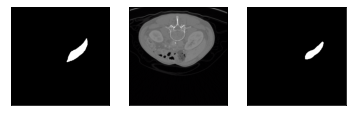

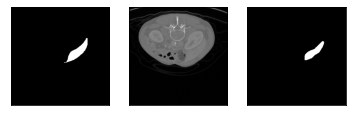

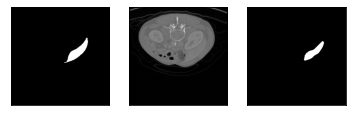

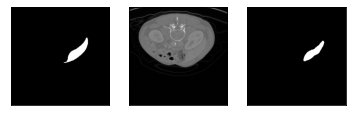

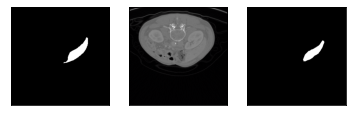

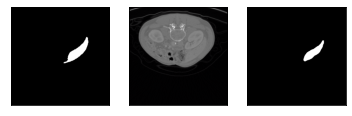

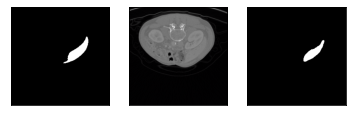

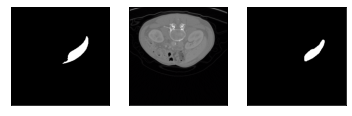

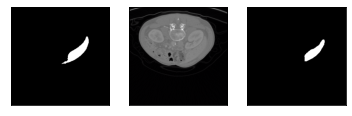

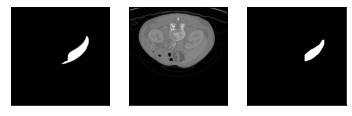

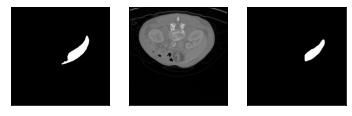

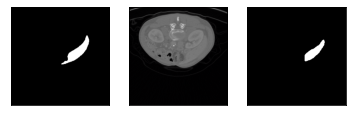

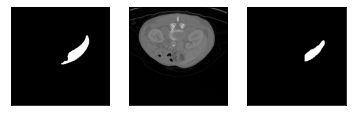

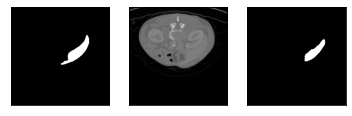

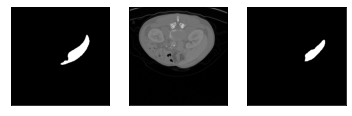

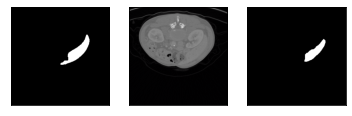

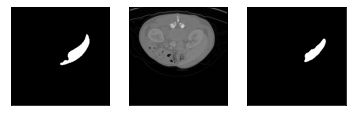

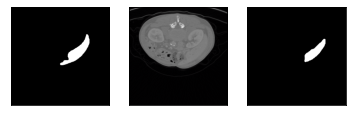

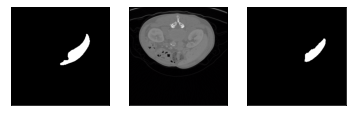

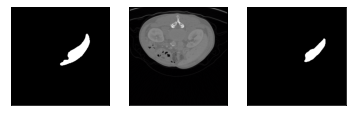

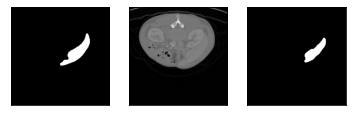

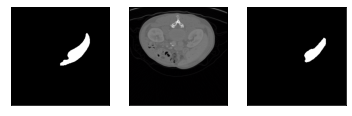

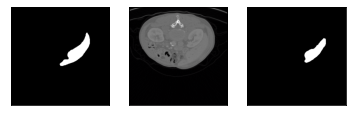

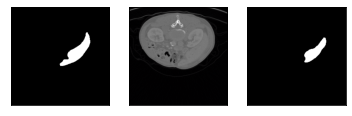

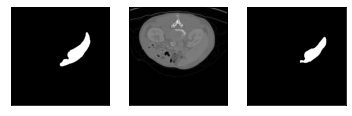

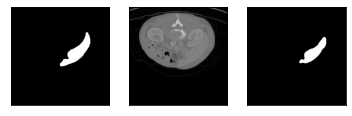

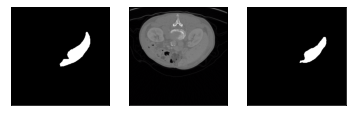

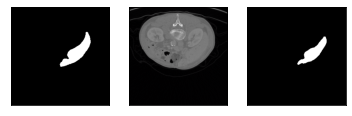

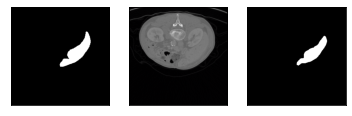

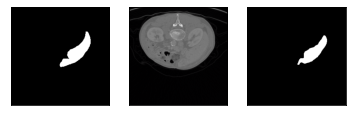

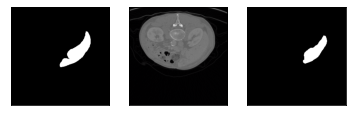

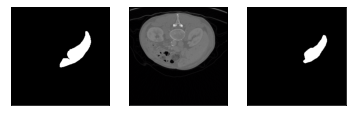

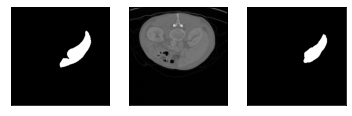

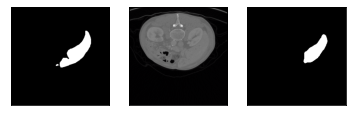

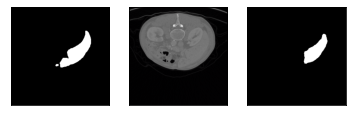

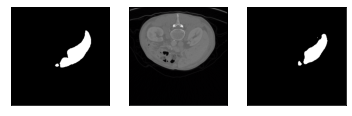

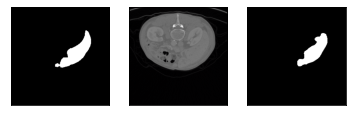

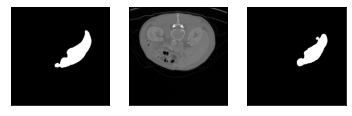

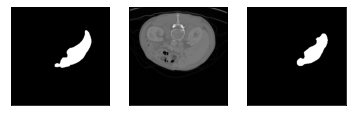

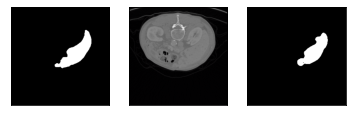

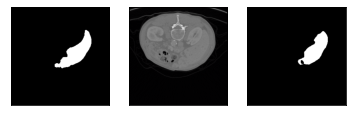

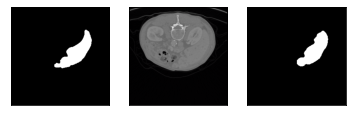

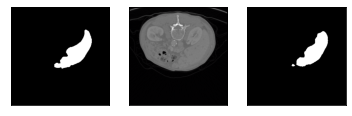

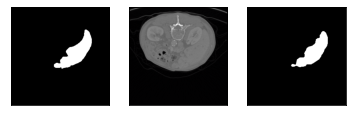

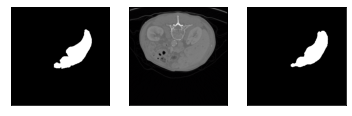

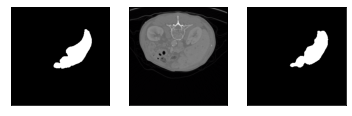

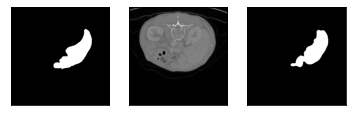

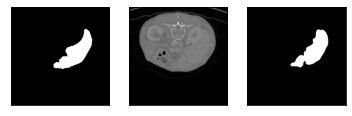

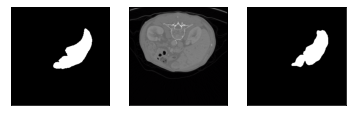

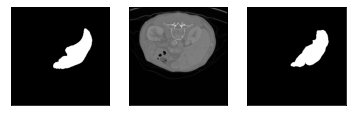

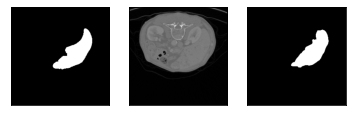

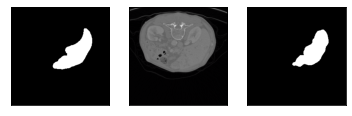

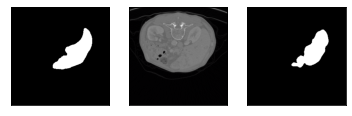

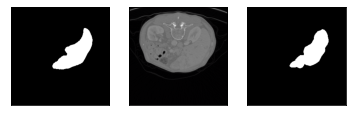

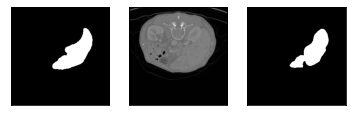

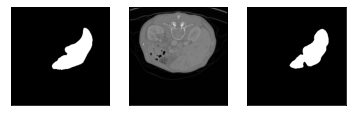

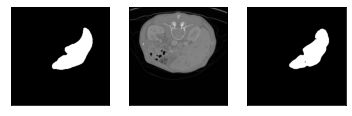

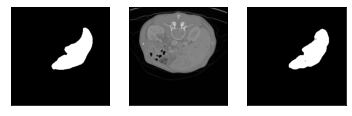

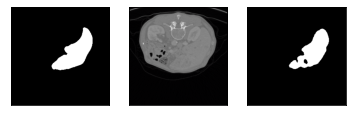

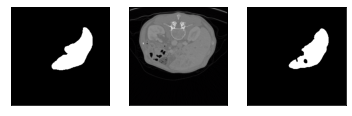

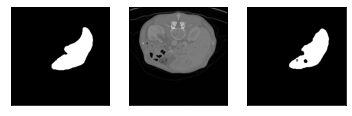

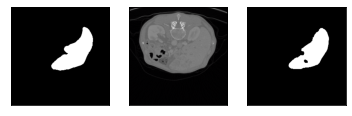

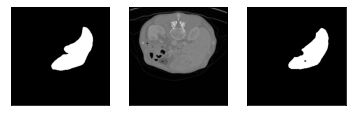

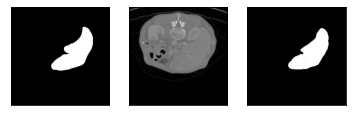

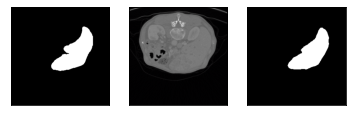

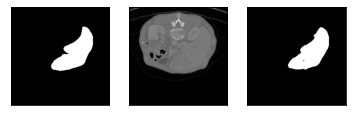

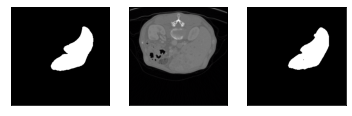

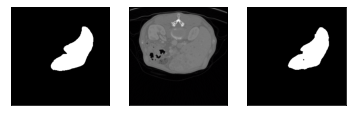

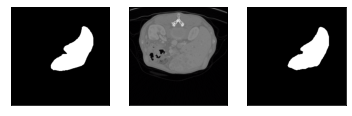

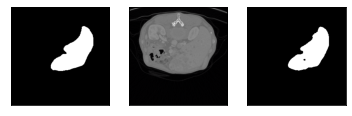

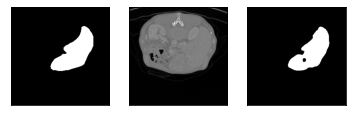

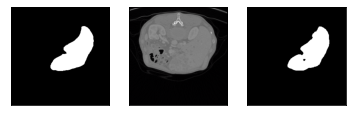

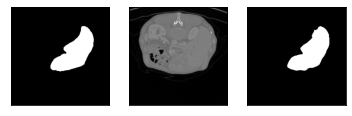

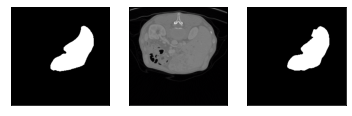

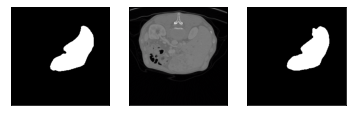

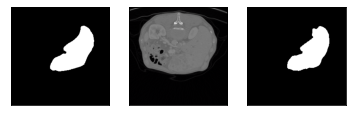

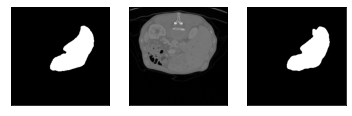

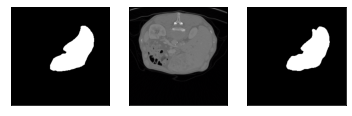

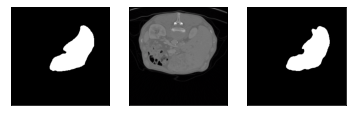

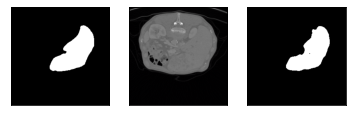

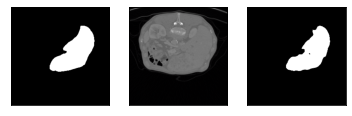

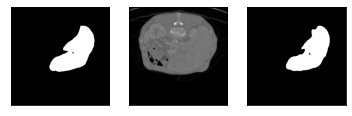

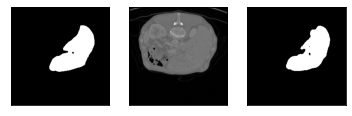

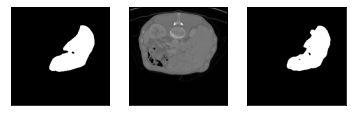

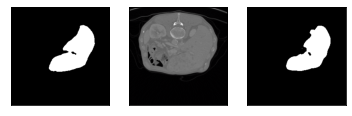

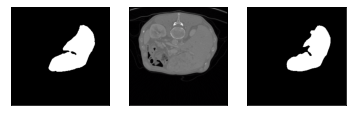

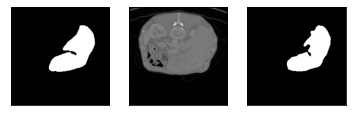

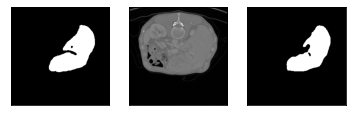

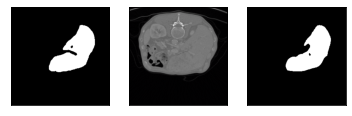

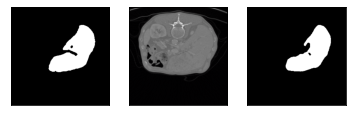

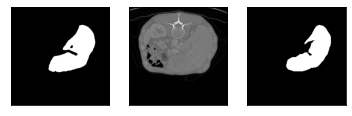

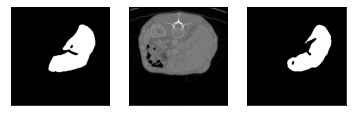

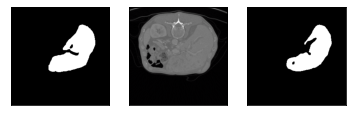

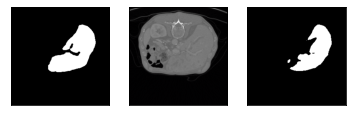

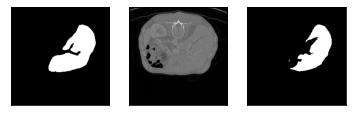

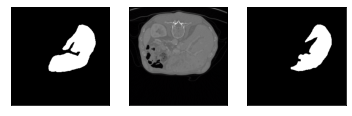

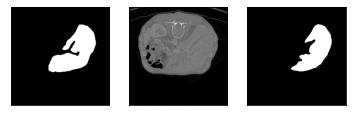

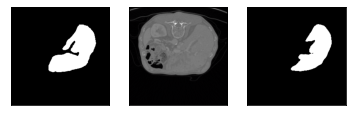

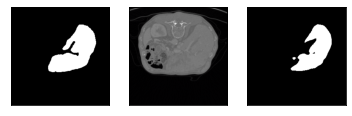

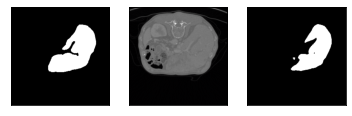

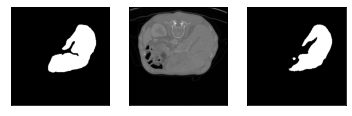

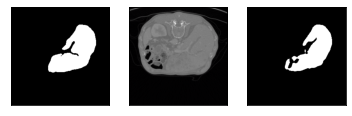

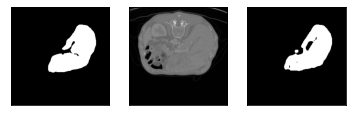

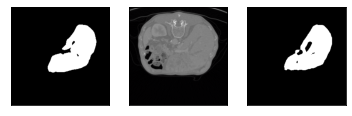

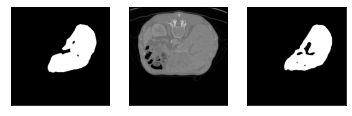

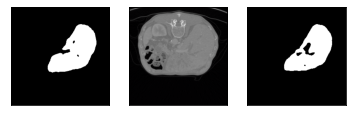

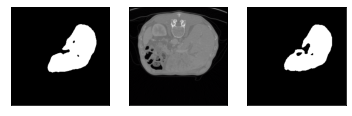

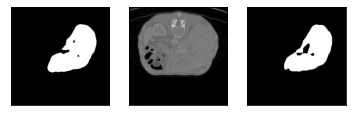

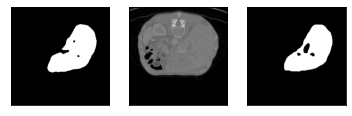

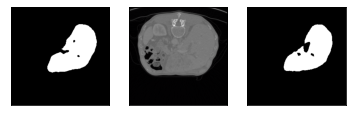

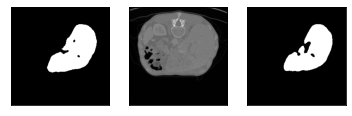

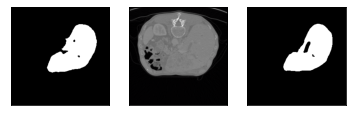

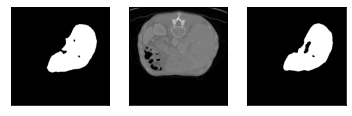

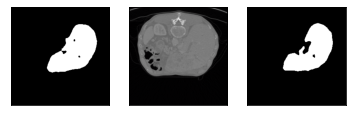

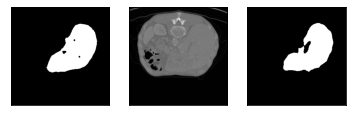

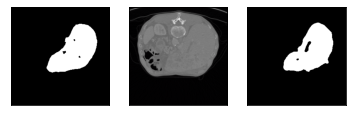

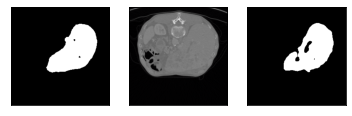

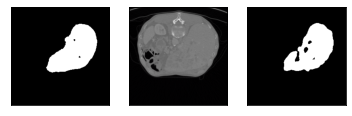

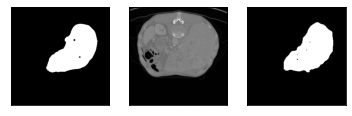

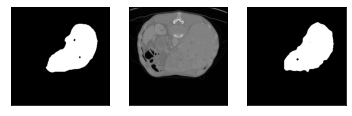

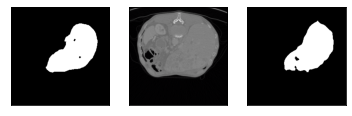

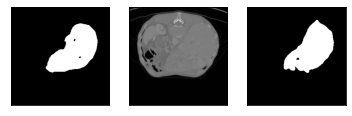

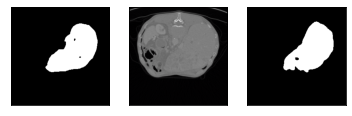

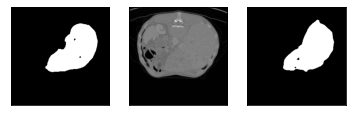

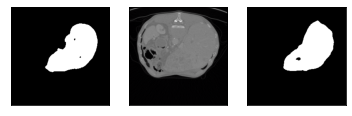

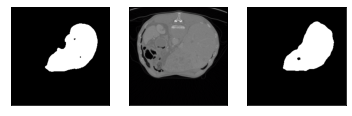

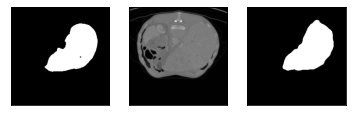

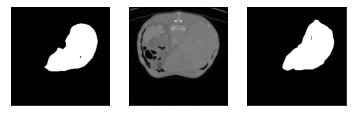

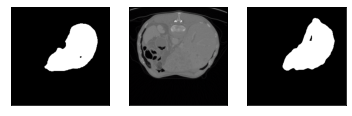

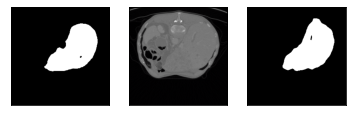

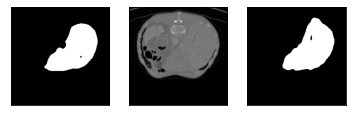

In [ ]:
# load data
for sn in range(111, 131):
    if args.kind == 'liver':
        dataset_test = LiverSegmentation(args, split=args.mode, study_num=sn)
    if args.kind == 'tumor':
        dataset_test = TumorSegmentation(args, split=args.mode, study_num=sn)
    print("num test img: ", len(dataset_test))
    if len(dataset_test) == 0:
        continue
    dataloader = DataLoader(dataset_test, batch_size=args.batch_size, shuffle=False, num_workers=0)

    # gpu use
    device = 'cuda'
    model.to(device)
    model.eval()

    # initialize scores
    cnt = 0
    total_precision = 0
    total_recall = 0
    total_time = 0
    total_cos = 0
    total_voe = 0
    total_assd = 0
    total_vd = 0
    # Dice, jaccard, VOE, ASSD, RVD, MSSD 
    # run inference
    for i, sample in enumerate(dataloader):
        image, target = sample['image'], sample['label']
        image = image.to(device)

        start_time = time.time()
        with torch.no_grad():
            output = model(image)
        timedelta = time.time() - start_time
        total_time += timedelta

        pred = output.data.cpu().numpy()
        target = target.cpu().numpy()
        pred = np.argmax(pred, axis=1)
        # print(np.unique(pred))
        # print(np.unique(target))

        image = image.cpu().numpy()
        for idx in range(len(pred)):
            if args.mode == 'val':
                ## scoring
                pred_ = pred[idx].astype(np.uint8)
                target_ = target[idx].astype(np.uint8)

                intersection = np.logical_and(target_, pred_)
                union = np.logical_or(target_, pred_)
                voe = 1.0 - np.sum(intersection)/np.sum(union)
                sds = surfd(target_, pred_)
                if len(sds) == 0:
                    assd = 0
                else:
                    assd = sds.mean()
                if np.sum(target_) == 0:
                    vd = 1.0
                else:
                    vd = abs((int(np.sum(pred_)) - int(np.sum(target_))) / float(np.sum(target_)))
                # iou_score = np.sum(intersection) / np.sum(union)
                tp = np.sum(np.logical_and(target_ == 1, pred_ == 1))/256**2
                fp = np.sum(np.logical_and(target_ == 0, pred_ == 1))/256**2
                tn = np.sum(np.logical_and(target_ == 0, pred_ == 0))/256**2
                fn = np.sum(np.logical_and(target_ == 1, pred_ == 0))/256**2

                target_ = target_.ravel()
                pred_ = pred_.ravel()

                cos_sim = np.dot(target_, pred_)/(np.linalg.norm(target_)*np.linalg.norm(pred_))
                precision = tp/(tp+fp)
                recall = tp/(tp+fn)
                voe = np.nan_to_num(voe, nan=1.0)
                cos_sim = np.nan_to_num(cos_sim, nan=1.0)
                precision = np.nan_to_num(precision, nan=1.0)
                recall = np.nan_to_num(recall, nan=1.0)

                total_cos += cos_sim
                total_precision+=precision
                total_recall+=recall
                total_voe += voe
                total_assd+=assd
                total_vd+=vd
            elif args.mode == 'vis':
                ##visualize(save)
                pred_ = pred[idx].astype(np.uint8)
                target_ = target[idx].astype(np.uint8)
                pred_[pred_ != 0] = 255
                target_[target_ != 0] = 255

                img_tmp = np.transpose(image[idx], axes=[1, 2, 0])
                img_tmp *= (0.229, 0.224, 0.225)
                img_tmp += (0.485, 0.456, 0.406)
                img_tmp *= 255.0
                img_tmp = img_tmp.astype(np.uint8)

                fig = plt.figure()
                fig.tight_layout()
                
                ax1 = fig.add_subplot(1, 3, 1)
                ax1.imshow(target_, cmap='gray')
                # ax1.set_title('Label')
                ax1.axes.xaxis.set_visible(False)
                ax1.axes.yaxis.set_visible(False)
                ax2 = fig.add_subplot(1, 3, 2)
                ax2.imshow(img_tmp, cmap=plt.cm.bone)
                # ax2.set_title('Original')
                ax2.axes.xaxis.set_visible(False)
                ax2.axes.yaxis.set_visible(False)
                ax3 = fig.add_subplot(1, 3, 3)
                ax3.imshow(pred_, cmap='gray')
                # ax3.set_title('Predict')
                ax3.axes.xaxis.set_visible(False)
                ax3.axes.yaxis.set_visible(False)

                # plt.show()
                os.makedirs('val/'+args.kind+f'/{str(sn)}/', exist_ok=True)
                plt.savefig('val/'+args.kind+f'/{str(sn)}/'+str(cnt)+'.png')
                plt.close(fig)
            cnt+=1
            print(cnt, end='\r')

    if args.mode == 'val':
        # print scores
        avg_time = total_time/cnt
        p = total_precision/cnt*100
        r = total_recall/cnt*100
        cos = total_cos/cnt*100
        f1 = 2*p*r/(p+r)*100
        voe = total_voe/cnt*100
        assd = total_assd/cnt
        vd = total_vd/cnt*100
        print(f"avg_time:{avg_time} precision:{p} recall:{r} dice:{f1} jaccard:{cos} voe:{voe} assd:{assd} vd:{vd}")

In [11]:
import glob
len(glob.glob('val/liver/*'))

3371